# Grid generation
In this notebook we generate the location grid, then we proceed to visualize trajectories on the grid.

We start with an inizialization block.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

with open("conf.yaml") as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)

base_path = conf["base_path"]
data_path = conf["data_path"]
out_path = conf["out_path"]
detour_radius = conf["detour_radius"]
lambdas = conf["lambdas"]
delta = conf["delta"]

cols = ["lat", "lon", "uid", "tid","date_time"]

# Define a basic Haversine distance formula
def haversine(lat1, lon1, lat2, lon2):
    
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    #total_meters = METERS * c
    r = 6371000 #radiu * 1000 to return meters
    return c * r



## Grid generation
Now we define a bounding box of the Beijing region and generate a grid according to it

In [3]:
import shapely.geometry
import pyproj

# Set up projections
p_ll = pyproj.Proj(init='epsg:4214')
p_mt = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point(115.7657, 39.6332)
ne = shapely.geometry.Point(116.7435, 40.1411)
# This is a wide region in the beijing area

stepsize = 6561.68 # 5000m grid step size
# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform SW point to 3857
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for NE

# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize
    #print("generated {:d} points".format(len(gridpoints)))

grid = [(p.x, p.y) for p in gridpoints]
cols = ("lon", "lat")
grid_df = pd.DataFrame(grid, columns=cols)

print("Finished generating a regular grid with {:d} locations".format(len(grid_df)))

/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the

Finished generating a regular grid with 204 locations


Now we serialize our grid as a .csv

In [4]:
grid_df.to_csv(out_path+"5000_m_grid.csv")

## Visualizing locations and trajectories
We use matplotlib to show our locations over beijing, then we proceed to use folium for a deeper visualization including detour radius and some user trajectories.

We proceed to load the dataset

In [2]:
dataset = pd.read_csv(data_path + "augmented_dataset.csv", usecols=cols, parse_dates = True)

(116.2, 116.59492864804434, 39.79999999999998, 39.998970237833184)


G:\Programs\Anaconda3\envs\movingpandas\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  from ipykernel import kernelapp as app


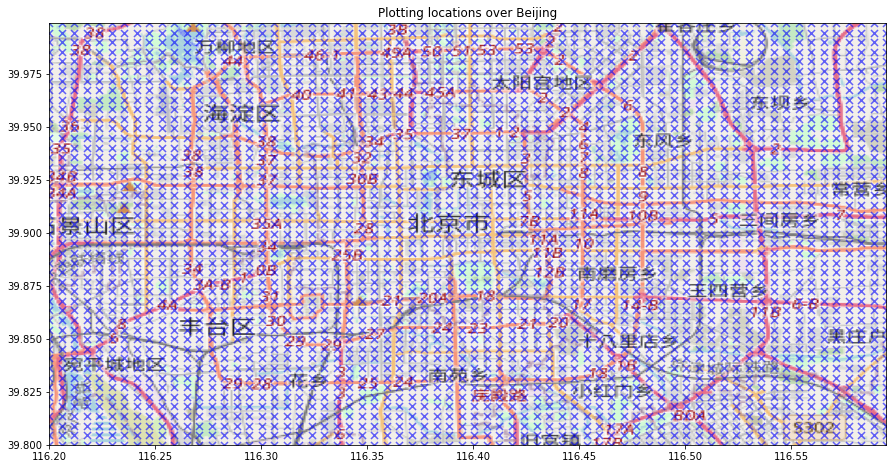

In [10]:
BBox = ((grid_df.lon.min(),   grid_df.lon.max(),      
         grid_df.lat.min(), grid_df.lat.max()))
print(BBox)
#we get our map
beijing = plt.imread(base_path + "pechino_crop.png")

fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(grid_df.lon, grid_df.lat, zorder=1, alpha= 0.6, c='b', s=50, marker = "x")
ax.set_title('Plotting locations over Beijing')

ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(beijing, zorder=0, extent = BBox, aspect= 'equal')

fig.savefig(out_path + "locations.jpg", quality = 95, bbox_inches='tight')

We save our figure to output folder

Now we extract a restricted set of locations from our grid for easier and faster data crunching

In [11]:
df_t = grid_df[(grid_df['lat'].between(39.8, 40.0)) & (grid_df['lon'].between(116.2, 116.6))].copy()
BBox_t = ((df_t.lon.min(),   df_t.lon.max(),      
         df_t.lat.min(), df_t.lat.max()))

print("There are a total of {:d} locations in our restricted bounding box".format(len(df_t)))

df_t["location"] = df_t.index.values
print(df_t.head())

There are a total of 2992 locations in our restricted bounding box
     lon        lat  location
1  116.2  39.804528         1
2  116.2  39.809057         2
3  116.2  39.813585         3
4  116.2  39.818112         4
5  116.2  39.822639         5


## Folium interactive map
We use a folium interactive map to show trajectories intersecting each location's detour radius.

In [12]:
import skmob
import folium

tdf = skmob.TrajDataFrame(dataset, latitude='lat', longitude="lon", datetime='date_time', user_id='uit', trajectory_id="tid")

m = folium.Map(location=[39.9042, 116.4074], tiles="Stamen Toner")

for lat, lon, index in zip(df_t.lat.values, df_t.lon.values, df_t.index.values):
    #folium.Marker([lat, lon], popup="location" + str(index), tooltip=str(index)).add_to(m)
    folium.Circle(
        location=[lat, lon],
        radius=100,
        popup='location {:d} radius'.format(index),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
        ).add_to(m)

#change this to plot more trajectories
trajs_to_plot = 30
for tid in tdf.tid.unique():
    tdf[tdf["tid"] == tid].plot_trajectory(m, weight=4, opacity=1, start_end_markers=False)
    trajs_to_plot -= 1
    if (trajs_to_plot == 0):
        break

m

Now we save our map on disk as an html file

In [14]:
m.save(outfile= out_path + "locations_grid_trajectories.html")

## Coverage probability for each of the locations
- calculate distances for all our locations
- run the coverage model on our distance sets

In [17]:
#for each user, for each trajectory of the user, get the distance of all its waypoints that are in our detour radius' range


dists = []
count = 0

for location in df_t.index.values:
    d_i_h = pd.DataFrame()
    d_i_h["distance"] = haversine(df_t.loc[location].lat, df_t.loc[location].lon, dataset["lat"].values, dataset["lon"].values)
    d_i_h = d_i_h[d_i_h.distance < detour_radius]
    if (len(d_i_h) > 0):
        d_i_h["uid"] = dataset["uid"]
        d_i_h["location"] = location
    else:
        d_i_h = pd.DataFrame({"location":location, "uid":np.nan, "distance":np.nan}, index=[0])
        count += 1
        #print(d_i_h)
    dists.append(d_i_h)
    
print("There are {:d} locations that have no points in detour radius' range".format(count)) 

There are 44 locations that have no points in detour radius' range


In [18]:
tot_dists = pd.concat(dists)
#users intersecting location 180's detour radius with one of their trajectories
#print(tot_dists[tot_dists.location == 196].uid.unique())
#print(tot_dists[tot_dists.distance == tot_dists.distance.min()])

In [19]:
tot_dists.to_csv(data_path+"tot_dists_500m.csv")

In [20]:
#print(tot_dists[(tot_dists.location == 196) & (tot_dists.uid == 3002)])
print(len(tot_dists.location.unique()))
print(tot_dists[tot_dists.location == 244])

2992
            distance     uid  location
701851    998.661412  3011.0       244
701852    993.863002  3011.0       244
701853    989.066462  3011.0       244
701854    984.271822  3011.0       244
701855    979.479108  3011.0       244
...              ...     ...       ...
11224922  712.461619    92.0       244
11224923  786.731965    92.0       244
11569378  996.196412   125.0       244
11569379  987.251066   125.0       244
11569380  994.637753   125.0       244

[5287 rows x 3 columns]


We compute the mean of our distances in order to set a proper scale for the exponential distribution

In [21]:
print(tot_dists.distance.mean())

665.0368426292501


We set up some lambda functions and vectorize the integral to exploit numpy's optimization (we get a much faster running speed)

In [407]:
import scipy.integrate as integrate

lam = 1/664.70 #da settare sul valore medio di tutte le distanze
#c = 0.4 
delta = 10

inner = lambda x: lam * (1/( (np.e)**(lam*x) ))
#print(inner(6))
#print(inner(16))
integral = lambda x: 1 - integrate.quad(inner, x, x+delta)[0]
vec_integral = np.vectorize(integral)


In [24]:
#these are the locations we are taking into account for our coverage model
print(tot_dists.location.unique())
locations = tot_dists.location.unique()
print(len(locations))

[   1    2    3 ... 3057 3058 3059]
2992


In [499]:
grid_coverage

location  probability
0            1     0.993983
1            2     0.800686
2            3     0.586369
3            4     0.701816
4            5     0.820579
...        ...          ...
2987      3055     0.434616
2988      3056     0.000000
2989      3057     0.000000
2990      3058     0.000000
2991      3059     0.879535

[2992 rows x 2 columns]

In [495]:
import scipy.integrate as integrate

def coverage(loc_array, tot_dists_df, lam, delta):
    coverage = pd.DataFrame()
    coverage["location"] = loc_array
    coverage["probability"] = calculate_coverage(loc_array, tot_dists_df, lam, delta)
    return coverage

def calculate_coverage(locations, tot_dists_df, lam, delta):
    
    lenght = len(locations)
    count = 0
    coverages = []
    
    #initialize coverage inner function
    lam = lam
    delta = delta
    inner = lambda x: lam * (1/( (np.e)**(lam*x) ))
    integral = lambda x: 1 - integrate.quad(inner, x, x+delta)[0]
    vec_integral = np.vectorize(integral)
    print("Calculating coverage with lambda set to: {:4f} and delta set to: {:f}".format(lam, delta))
    
    for loc in locations:
        
        #if the location has no points whatsoever, assign 0 to the probability and continue
        if(tot_dists_df[tot_dists_df.location == loc].uid.isnull().values.any()):
            coverages.append(0)
            count += 1
            print("Computed coverage on {:d} out of {:d} locations, with lambda set to {:f}".format(count, lenght, lam), end="\r")
            continue
        
        tot_dists_location = tot_dists_df[tot_dists_df.location == loc]
        uids = tot_dists_location.uid.unique()
        #print(uids)
        user_probs = []

        for user in uids:
            #print(user)
            tot_dists_user = tot_dists_location[(tot_dists_location.uid == user)]
            
            #print(tot_dists_user)
            inner_vals = vec_integral(tot_dists_user.distance.values)
            prob = 1 - np.prod(inner_vals)
            user_probs.append(prob)

        location_coverage = 1 - np.prod(user_probs)
        coverages.append(location_coverage)
        count += 1
        print("Computed coverage on {:d} out of {:d} locations, with lambda set to {:f}".format(count, lenght, lam), end="\r")
        
    return coverages

#calculates coverages on multiple lambda values and serializes them on disk
def coverage_multiple_lambdas(lambdas, delta, locations, tot_dists_df):
    for value in lambdas:
        lam = value
        coverages = coverage(locations, tot_dists, lam, delta)
        #merge with df_t dataframe with location positions on "location" id then serialize on disk
        merged = df_t.merge(coverages, on="location")
        name = "coverages_" + str(value).replace(".", ",") + "_lambda.csv"
        merged.to_csv(data_path + name)
        
        

In [54]:
#print(lambdas)
coverage_multiple_lambdas(lambdas, delta, locations, tot_dists)

Calculating coverage with lambda set to: 0.010000 and delta set to: 10.000000
Calculating coverage with lambda set to: 0.003333 and delta set to: 10.000000
Calculating coverage with lambda set to: 0.001429 and delta set to: 10.000000


## Seaborn Heatmap
We plot a seaborn heatmap representing our coverage

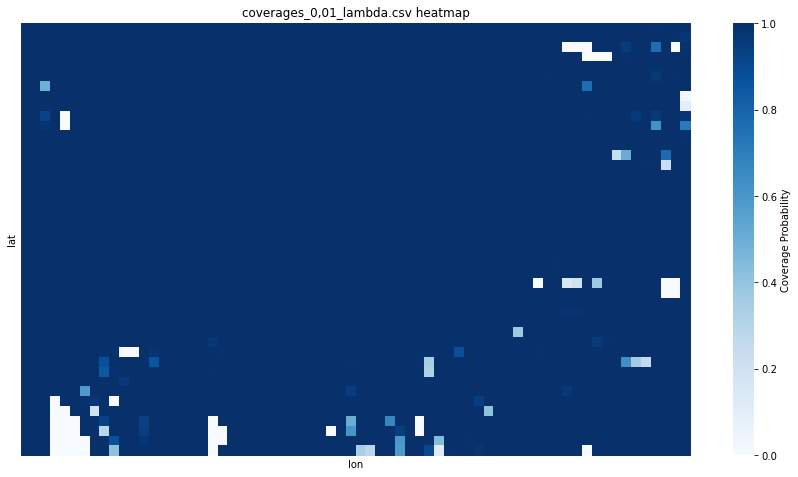

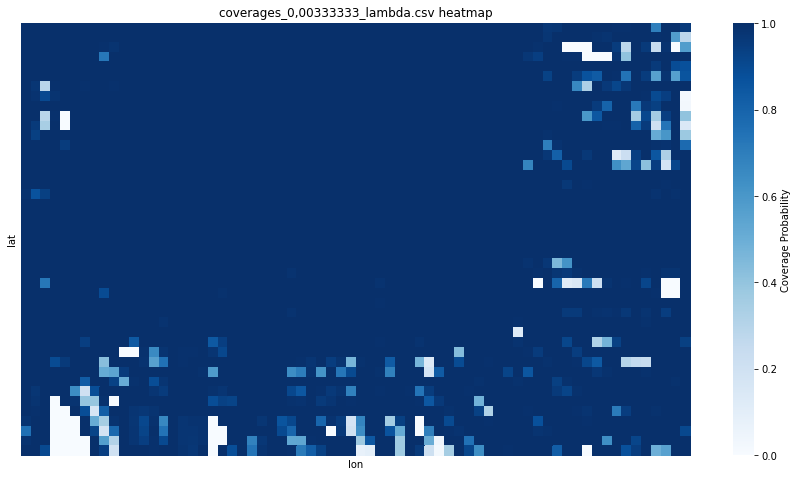

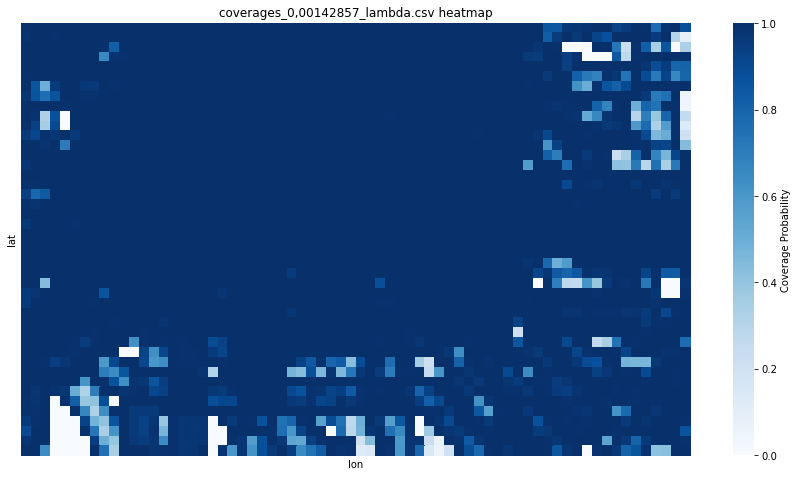

In [55]:
import seaborn as sns

files = ["coverages_0,01_lambda.csv", "coverages_0,00333333_lambda.csv", "coverages_0,00142857_lambda.csv"]

for name in files:
    
    x = []
    y = []
    z = []
    locs = []

    coverage = pd.read_csv(data_path + name)
    #print(coverage.head())

    for lat, lon, probability, locnum in zip(reversed(coverage.lat.values), coverage.lon.values, coverage.probability.values, coverage.location.values):
        x.append(lat)
        y.append(lon)
        z.append(probability)
        locs.append(locnum)

    #print(len(x), len(y), len(z))

    df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
    df.columns = ["lat","lon","coverage"]
    pivotted= df.pivot("lat","lon","coverage")

    annots = pd.DataFrame.from_dict(np.array([x,y,locs]).T)
    annots.columns = ["lat","lon","location"]
    annots.location = annots.location.astype(int)
    annots_pivotted= annots.pivot("lat","lon","location")
    #print(annots_pivotted)

    plt.subplots(figsize=(15,15))
    ax = plt.axes()
    
    #palette = sns.color_palette("colorblind")

    heat = sns.heatmap(pivotted, ax = ax, xticklabels=False, yticklabels=False, square=True, annot=False, cmap="Blues", cbar_kws={"shrink": .53, "label": "Coverage Probability"})
    ax.set_title(name + " heatmap")
    plt.savefig(out_path + name + "_heatmap.jpg")
    plt.show



In [58]:
#check the difference between two coverage probabilities

for file in files:
    print(pd.read_csv(data_path+file).probability.mean())
    




0.9781244804156746
0.9596628381533805
0.9515968863098311


# Different strategies for location picking
we investigate new strategies for choosing our locations.

We begin with a random picking and then we get picks from an external csv.

## Random picking

In [16]:
import random as rand

#picking 50 random points in our inner bounding box perimeter
points = 50
rd_pts = [(rand.uniform(39.8, 40.0), (rand.uniform(116.2, 116.6))) for i in range(points)]
cols = ("lat", "lon")
rd_locations = pd.DataFrame(rd_pts, columns=cols)

In [17]:
print(rd_locations.head())

         lat         lon
0  39.890662  116.312914
1  39.965569  116.555597
2  39.876707  116.473412
3  39.844701  116.392094
4  39.974621  116.233108


Now we visualize the random grid in a folium map

In [18]:
rd_m = folium.Map(location=[39.9042, 116.4074], tiles="Stamen Toner")

for lat, lon, index in zip(rd_locations.lat.values, rd_locations.lon.values, rd_locations.index.values):
    #folium.Marker([lat, lon], popup="location" + str(index), tooltip=str(index)).add_to(rd_m)
    folium.Circle(
        location=[lat, lon],
        radius=1000,
        popup='location {:d} radius'.format(index),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
        ).add_to(rd_m)

#change this to plot more trajectories
trajs_to_plot = 20
for tid in tdf.tid.unique():
    tdf[tdf["tid"] == tid].plot_trajectory(rd_m, weight=4, opacity=1, start_end_markers=False)
    trajs_to_plot -= 1
    if (trajs_to_plot == 0):
        break

rd_m

## CSV loading
we try loading a previously generated csv with POIs (such as subway stations, in this example) in order to use them as locations.

In [310]:
df = pd.read_csv("/Users/tommasocolella/desktop/tesi/beijing_subway_stations.csv")
df = df[(df['lat'].between(39.8, 40.0)) & (df['lon'].between(116.2, 116.6))]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 308
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    207 non-null    object 
 1   lat     207 non-null    float64
 2   lon     207 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.5+ KB
None


In [312]:
csv_m = folium.Map(location=[39.9042, 116.4074], tiles="Stamen Toner")

for lat, lon, name in zip(df.lat, df.lon, df.name):
    #folium.Marker((lat, lon), popup=name).add_to(csv_m)
    folium.Circle(
        location=[lat, lon],
        radius=250,
        popup='{:s} station radius'.format(name),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
        ).add_to(csv_m)

#change this to plot more trajectories
trajs_to_plot = 20
for tid in tdf.tid.unique():
    tdf[tdf["tid"] == tid].plot_trajectory(csv_m, weight=4, opacity=1, start_end_markers=False)
    trajs_to_plot -= 1
    if (trajs_to_plot == 0):
        break


csv_m

## Considerations on fixed locations
Metro stations might be especially useful to get coverage from people going by foot, while other types of facilities might be exploited for different kinds of mobility profiles.
Motorway Junctions could be good if we had to address a mainly car-based mobility profile, while bycicle lanes could be used for cyclists.